In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston, load_diabetes

## 1. Synthetic Data: Comparative Analysis & Learning Curves
#### (a) Generate a dataset by sampling 1,200 values from a cubic function with noise added. Set values to range from 0 to 1. (Code)

In [2]:
nums = np.random.rand(1200, 2)
X, noise = nums[:,0], nums[:,1]*10e-5

param = np.random.rand()

Y = param*(X**3)

#### (b) Create a 70/30 train/test split of the dataset.

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

X_train, X_test = X_train.reshape(-1,1), X_test.reshape(-1,1)
Y_train, Y_test = Y_train.reshape(-1,1), Y_test.reshape(-1,1)

#### (c) Plot learning curves for the following two regression models: linear and polynomial (to the 4th degree). Vary the amount of training data by increments of at most 120 (i.e., at least 10 training sizes), evaluate using mean squared error, and remember to show curves for both the training and test datasets.

See graphs below.

In [22]:
def models(X_train, X_test, Y_train, Y_test, shrinkage='ridge', d=1, alpha=1.0):
    
    if shrinkage == 'ridge':
        model = Ridge(alpha=alpha, random_state=42)
    if shrinkage == 'lasso':
        model = Lasso(alpha=alpha, random_state=42)
    if not shrinkage:
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=d)), 
            ('linear', LinearRegression())
        ])
        
    model.fit(X_train, Y_train)    
    
    Y_pred = model.predict(X_test)

    # evaluate training (3-fold cv) and testing MSEs
    train_MSE = np.mean((-1 * cross_val_score(model, X_train, Y_train,
                                              scoring='neg_mean_squared_error')))
    test_MSE = mean_squared_error(Y_test, Y_pred)
    
    return train_MSE, test_MSE

In [23]:
def plot_learning_curves_increse_train_size(d):
    
    """ unregularized linear regressions """

    result = []
    
    for size in [i*84 for i in range(1,11)]:  # increment training set size by multiples of 84
        curr_X_train, curr_Y_train = X_train[:size,:], Y_train[:size,:]
        train_error, test_error = models(curr_X_train, X_test, curr_Y_train, Y_test, 
                                         shrinkage=None, d=d)
        result.append([train_error, test_error, size])

    result = np.asarray(result)    
    plot_(result, d)


def plot_learning_curves_increase_alpha(shrinkage='ridge', d=1):
    
    """ ridge and lasso regressions """
    
    result = []
    
    # increment alpha
    for a in [0., 0.2, 0.5, 1., 1.2, 1.5, 2., 3., 4., 5., 10., 12., 15., 20., 25., 30., 50.]:
        train_error, test_error = models(X_train, X_test, Y_train, Y_test,
                                         shrinkage=shrinkage,
                                         alpha=a, d=d)
        result.append([train_error, test_error, a])
        
    result = np.asarray(result)
    plot_(result, a, model=shrinkage, x_axis='alpha')

In [24]:
def plot_(results, d=1, alpha=1.0, model='linear', x_axis='train_size'):
    
    train_MSE, test_MSE, x_coord = results[:,0], results[:,1], results[:,2]
    
    plt.figure(figsize=(12,7))
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    
    t = ''
    if model == 'linear':
        t = "Linear regression, degree={}\ntraining set size: {}".format(d, x_coord)
    elif model == 'ridge':
        t = "Ridge regression\nalpha = {}".format(x_coord)
    elif model == 'lasso':
        t = "Lasso regression\nalpha= {}".format(x_coord)
    plt.title(t)
    
    x_label = 'number of training examples' if x_axis=='train_size' else 'alpha'
    plt.ylabel('MSE')
    plt.xlabel(x_label)
    
    plt.plot(x_coord, train_MSE, color='green', linewidth=2, linestyle='-.')
    plt.plot(x_coord, test_MSE, color='red', linewidth=2, linestyle=':')
    plt.legend(['training MSE', 'test MSE'])
    
    plt.show()

#### (d) Write a discussion analyzing and comparing the two models. Explain which model performs better and why. Also, address which models you think are underftting versus overftting and explain why. Final, discuss the impact of increasing the amount of training data on both models. Your discussion should consist of two to three paragraphs.

The below graph shows the performance of a simple linear regression model (degree = 1) as the training dataset size increases. The green line and the red dotted line indicate the changes in training and testing errors, respectively. <br />

When the training dataset is very small (n < 100), the model overfits to a very few training examples. This leads to a large gap between the relatively low training error and a much higher testing error. While the training dataset's size increases to around n = 168, the model's performance monotonically increases: the test MSE sharply decrease while the training MSE increases to its first peak. The training and testing MSEs changed at different rates and towards different directions as the model is trained with more data, but the red dotted line clearly indicates the overall decreasing trend of the test MSE. At around n = 420, the model's performance on training and testing datasets are very similar. The training MSE now provide a much more accurate estimate of its performance on new data.

The improvement slows down as we increase the size of training data. Despite the decreasing training error, the linear model's performance on test data does not improve much more after n = 588. After n = 756, the training MSE's green line also hits a plateau. Feeding more training data to the model does not seem to improve its performance in terms of MSE. At this point, the linear regression model has high bias and underfits to the training data.

With over 800 training samples, the model achieves its best performance with a test MSE less than 1.85e-4.

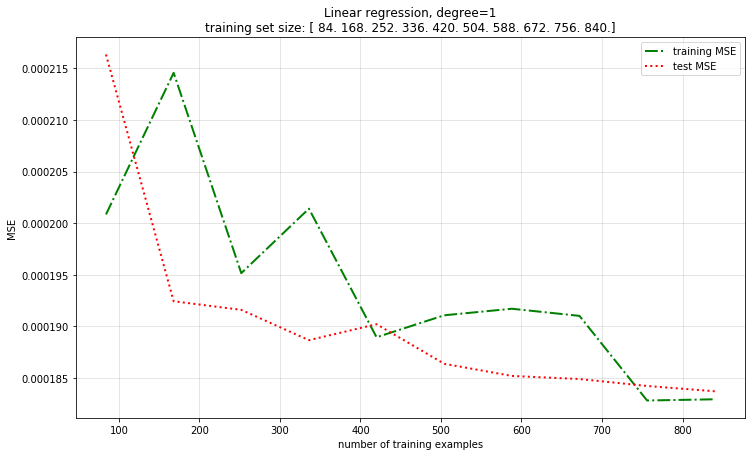

In [7]:
plot_learning_curves_increase_train_size(d=1)

One way to address the underfitting problem is to use a more flexible model with higher variance and lower bias. Subsequent graphs show the training MSE and testing MSE of 2nd-, 3rd- and 4th-degree linear regression models trained and tested with the same datasets. To ensure accurate comparisons, subsets of training samples used to test how increasing training dataset size would affect model performance are exactly the same for each model.

Compared to the first graph (degree = 1), the quadratic linear regression plotted below performs much better on both training and testing data. The overall trends of these two lines are similar to those in the first model: the model initially overfitted to the small training dataset with high test error and low training error, and eventual underfitted to the large training dataset with a stable test error. However, the overall MSEs are on a much smaller scale compared to the simple linear regression model. The quardratic model continues to improve with more training data until around n = 500; it achieves a lowest training MSE of less than 5.5e-6.

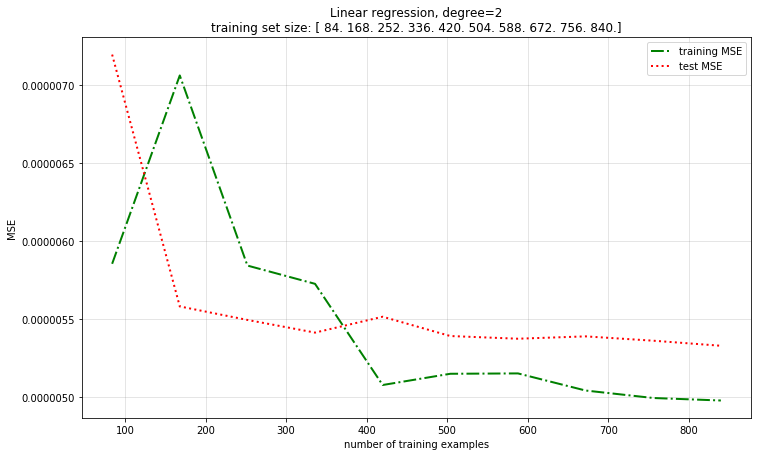

In [8]:
plot_learning_curves_increase_train_size(d=2)

The cubic polynomial function performs even better; the best test MSE is less than 0.4E-33 when n = 756. This confirms with the original sampling method (cubic function with noise). This model's best performance on test data is much better than that of the quadratic function. 

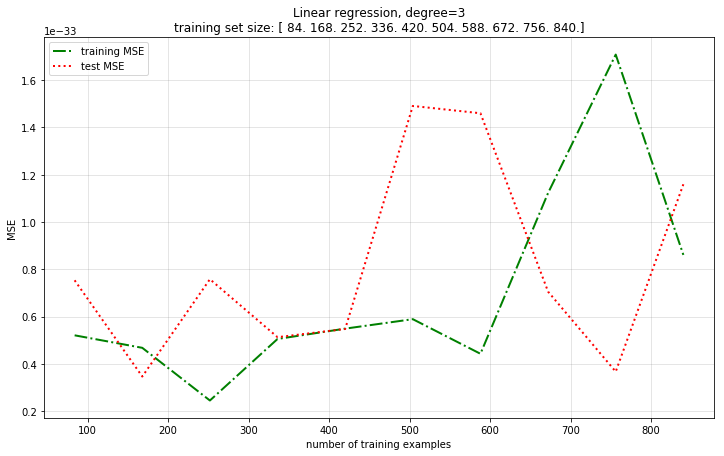

In [11]:
plot_learning_curves_increase_train_size(d=3)

In the fourth graph (degree = 4), the lowest test MSE is less than 0.2E-33 when n = 504. This is about 0.2E-33 lower than the best test MSE the previous model achieved. By significantly increasing the model's complexity from cubic to quartic, the performance improvement is less significant compared to the change from quadratic to cubic.

The gap between training MSE and testing MSE at the far right side of the graph (n = 840) indicates that the model is overfitting to the training set. Adding more training examples will help to bring the two curves together.

In contrast with the first two linear functions (degrees = 1 and 2) that underfit to training data when n = 800, the quartic function is much more flexible and requires more training data to prevent overfitting.

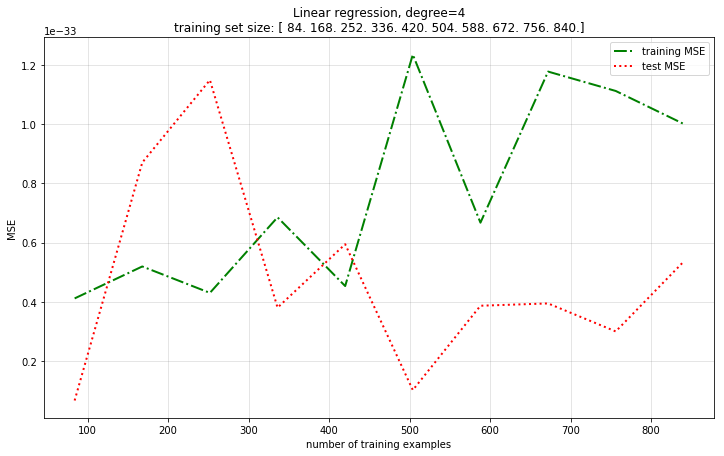

In [10]:
plot_learning_curves_increase_train_size(d=4)

## 2. Real Data: Comparative Analysis & Feature Analysis
#### (a) Load a real dataset not covered in class that is designed for the regression problem; e.g., from sklearn.datasets, Kaggle, your own data, etc. (Code)

In [ ]:
del X
del Y
del X_train
del Y_train
del X_test
del Y_test

In [2]:
X, Y = load_boston(return_X_y=True)
X.shape

(506, 13)

In [9]:
boston = load_boston()
print(boston.feature_names, boston.DESCR)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT'] Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-va

#### (b) Create a 70/30 train/test split of the dataset. (Code)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

#### (b) Create a 70/30 train/test split of the dataset. (Code)
##### (c) Train and evaluate the predictive performance for each of the following regression models: linear, ridge, lasso, and polynomial (to the 4th degree). Evaluate using mean squared error. Report all values in a single table. (Code and Write-up)

In [11]:
model_list = ['Linear (degree=1)','Poly (degree=2)', 'Poly (degree=3)', 'Poly (degree=4)',
              'Linear Ridge', 'Linear Lasso',]

train_MSE_list, test_MSE_list = [], []

# linear regression degrees from 1 to 4
for degree in range(1,5):
    train_MSE, test_MSE = models(X_train, X_test, Y_train, Y_test, shrinkage=None, d=degree)
    train_MSE_list.append(train_MSE)
    test_MSE_list.append(test_MSE)

# ridge regression (degree = 1)
train_MSE_ridge, test_MSE_ridge = models(X_train, X_test, Y_train, Y_test, shrinkage='ridge', d=1, alpha=2.0)
train_MSE_list.append(train_MSE_ridge)
test_MSE_list.append(test_MSE_ridge)

# lasso (degree = 1)    
train_MSE_lasso, test_MSE_lasso = models(X_train, X_test, Y_train, Y_test, shrinkage='lasso', d=1, alpha=2.0)
train_MSE_list.append(train_MSE_lasso)
test_MSE_list.append(test_MSE_lasso)

# print out results in a table
c1 = pd.DataFrame(model_list, columns=['model'])
c2 = pd.DataFrame(train_MSE_list, columns=['training MSE'])
c3 = pd.DataFrame(test_MSE_list, columns=['test MSE'])
pd.concat([c1, c2, c3], axis=1).set_index('model')

,training MSE,test MSE
model,,
Linear (degree=1),25.526617,24.559878
Poly (degree=2),161.270237,39.003460
Poly (degree=3),2251.511421,105507.696412
Poly (degree=4),4836.139457,615990.198888
Linear Ridge,25.152969,25.570282
Linear Lasso,35.856631,31.550891


In [12]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
print("Simple linear regression (degree = 1)\nIntercept: {}\nCoefficients:{}".format(lr.intercept_, lr.coef_))

Simple linear regression (degree = 1)
Intercept: 28.710349291123286
Coefficients:[-5.38860051e-02  2.60937784e-02 -4.34719202e-02  4.02418733e+00
 -1.26674048e+01  4.16578020e+00  2.44296202e-04 -1.34579265e+00
  2.38481981e-01 -9.41760957e-03 -8.03971070e-01  1.20533527e-02
 -6.18761013e-01]


##### (d) For the top-performing regression model, report the learned feature coefficients. (Code and Write-up)

In [14]:
# model with the lowest test MSE is the quadratic linear regressor.
m = Pipeline([
    ('poly', PolynomialFeatures(degree=2)), 
    ('linear', LinearRegression())
]).fit(X_train, Y_train)

poly = m.named_steps['poly']
lr = m.named_steps['linear']

print("Output features: ", poly.n_output_features_)
print("Linear regression (degree = 1), intercept: {}\nCoefficients: {}".format(lr.intercept_, lr.coef_))

Output features:  105
Linear regression (degree = 1), intercept: -3935790066.57654
Coefficients: [ 3.93578982e+09 -6.74088782e+00  5.38979020e-01 -5.45270612e+00
  2.70407705e+01  1.10436816e+02  1.23745897e+01  1.13489495e+00
 -1.02573778e+01  2.92801330e+00  4.77581934e-01  4.35721975e+00
  2.75603596e-01 -1.15565010e+00  8.87384495e-03  8.51317778e-01
  4.70649180e-01  2.46880177e+00 -2.59554019e+00  4.56222286e-02
 -7.95967801e-03  5.37151855e-01 -3.25232140e-02  1.43385584e-03
 -9.19218720e-02  1.18517808e-03  1.31860023e-02 -9.61377263e-04
  1.02850286e-02 -1.05254503e-01  4.52563268e-01  2.13766089e-01
 -2.30372708e-03  5.08030874e-02 -1.92858015e-02  3.34707485e-04
  8.27251191e-03 -6.64676685e-03  1.20751564e-02  6.59421855e-02
 -3.24907454e-01  1.92453048e+00  2.01425693e-01 -3.39983079e-03
  1.41455620e-01  2.05163885e-01 -2.35633937e-03  3.24605594e-02
  2.67301152e-03 -2.62966727e-02  2.70407705e+01 -3.48059038e+01
 -4.85985424e+00 -5.51446148e-02 -1.59077085e+00 -4.856582

##### (e) Write a discussion analyzing and comparing the four models. Explain which model(s) perform the best/worst and why you think this occurs. Also discuss which features are most predictive for the top-performing model and why this may be. Your discussion should consist of two to three paragraphs. (Write-up)

Polynomial linear regressions build upon the simple multivariate linear regression model (degree = 1) by raising the power of each $X_i$ $(i = 1, ..., 13)$ and including interaction terms ($X_0X_1$, $X_1X_2$, etc.). As the degree goes up, the number of predictive features increases rapidly because the interaction terms are combinations of all existing features. The polynomial regression models increases model complexity and have higher variances than the simple linear regression. Ridge and lasso, on the other hand, attempt to reduce variance by a slight increase in bias.

According to the table above, the quadratic linear regression performs the best (lowest test MSE).

The 1-degree simple linear regression is likely underfitting the training data. The complexity increases as the degree of polynomial increases; the quadratic function therefore outperforms the first one. The 3rd- and 4th- degree polynomials are probably too complex to accurately model the data since they have many output features; this leads to the very high MSEs on both training and testing datasets. 

Ridge and Lasso perform better than the high-degree (d >= 3) polynomial linear regressions because they are based on simple linear regression (degree = 1) and constrain large coefficients. As it will be discussed in 3(c), they did not improve the linear model's performance because the simple linear model is underfitting the data.

Judging by the degree = 1 and degree = 2 linear regression models and their p-values, the most predictive features are $X_6$, $X_8$, $X_{11}$, $X_{12}$ and $X_{13}$. These features correspond to:
- "PTRATIO" pupil-teacher ratio by town;
- "B": 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town; and 
- "LSTAT": % lower status of the population. 

Since OLS on this dataset has the potential problem of multicollinarity, one would need to check VIFs for the accuracy of t-test and combine/drop redundant features to find the most predictive features.

### 3. Real Data: Tuning Hyperparameters for Regularized Models
##### (a) Use the same training and test datasets from step 2c.

In [5]:
del X
del Y
del X_train 
del X_test 
del Y_train
del Y_test 

X, Y = load_boston(return_X_y=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

##### (b) Plot performance curves for the following regression models when varying alpha: ridge and lasso. Vary alpha to have at least 10 values and evaluate using mean squared error. (Code and Write-up)

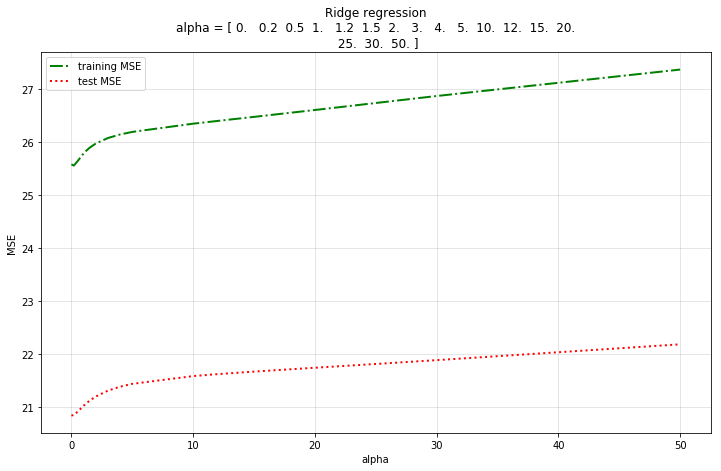

In [11]:
plot_learning_curves_increase_alpha(shrinkage='ridge')

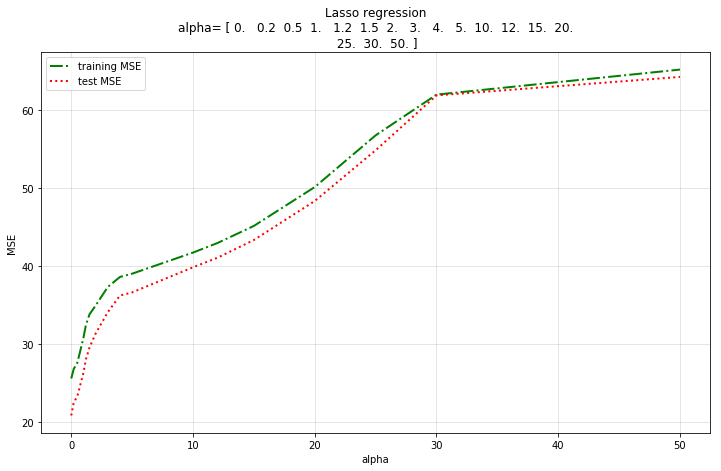

In [13]:
import warnings
warnings.filterwarnings("ignore") # suppress sklearn.linear_model.Lasso() warnings for alpha==0

plot_learning_curves_increase_alpha(shrinkage='lasso')

##### (c) Write a discussion analyzing and comparing the two types of regression models. Explain the impact of the alpha parameter. Also, discuss which model performs the better and why you think this occurs. The discussion should consist of two to three paragraphs. (Write-up)

Ridge vs lasso and the impact of alpha:
- Both are shrinkage methods that constrain the coefficient estimates for linear regression and shrink them towards zero. These two methods can reduce variance with a small increase in bias. 
- Ridge imposes L2 penalty by finding coefficients $\beta_i$ that minimizes $RSS + \alpha\sum\beta_i^2$. The greater $\alpha$ is, the heavier penalty it imposes; the coefficients are therefore smaller. 
- Lasso imposes L1 penalty by finding coefficients $\beta_i$ that minimizes $RSS + \alpha\sum |\beta_i|$. Similar to ridge, increasing $\alpha$ in ridge regression shrinks the coefficients towards 0. The main difference from ridge is that lasso can perform feature selection by shrinking some coefficients to 0: Lasso shrinks coefficients whose absolute values are are greater than $\alpha/2$ by a constant $\alpha/2$; coefficients with smaller absolute values are reduced to 0. Ridge regression shrinks all estimated coefficients by the same proportion and can preserve all features (never equal to zero).
- When $\alpha == 0$, both ridge and lasso are equivalent to least square regression. As we increase $\alpha$
, some coefficients become 0 in lasso.

Performance:
- As mentioned before, the simple linear regression (degree = 1) has relatively high bias and underfits to the Boston dataset. Therefore, both Lasso and Ridge achieve best performances (lowest MSEs) when alpha = 0 (no regularization). As this parameter increases, the model's performance deterioriate because the model's variance goes down as its bias increases.

- Ridge and lasso did not help to improve the linear model's performance since the dataset has only 13 features for 506 examples and does not seem to have the problem of high variance / overfitting. In the case of simple linear regression, increasing complexity (increasing degree of polynomials from 1 to 2) is more effective than reducing it (imposing shrinkage).

## re-do questions 2 and 3 on diabete dataset since Boston was used for in-class lab
## 2. Real Data: Comparative Analysis & Feature Analysis
#### (a) Load a real dataset not covered in class that is designed for the regression problem; e.g., from sklearn.datasets, Kaggle, your own data, etc. (Code)
#### (b) Create a 70/30 train/test split of the dataset. (Code)
##### (c) Train and evaluate the predictive performance for each of the following regression models: linear, ridge, lasso, and polynomial (to the 4th degree). Evaluate using mean squared error. Report all values in a single table. (Code and Write-up)

In [39]:
del X
del Y
del X_train
del Y_train
del X_test
del Y_test
del train_MSE_list
del test_MSE_list

In [35]:
X, Y = load_diabetes(return_X_y = True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

model_list = ['Linear (degree=1)','Poly (degree=2)', 'Poly (degree=3)', 'Poly (degree=4)',
              'Linear Ridge', 'Linear Lasso',]

train_MSE_list, test_MSE_list = [], []

# linear regression degrees from 1 to 4
for degree in range(1,5):
    train_MSE, test_MSE = models(X_train, X_test, Y_train, Y_test, shrinkage=None, d=degree)
    train_MSE_list.append(train_MSE)
    test_MSE_list.append(test_MSE)

# ridge regression (degree = 1)
train_MSE_ridge, test_MSE_ridge = models(X_train, X_test, Y_train, Y_test, shrinkage='ridge', d=1, alpha=20)
train_MSE_list.append(train_MSE_ridge)
test_MSE_list.append(test_MSE_ridge)

# lasso (degree = 1)    
train_MSE_lasso, test_MSE_lasso = models(X_train, X_test, Y_train, Y_test, shrinkage='lasso', d=1, alpha=20)
train_MSE_list.append(train_MSE_lasso)
test_MSE_list.append(test_MSE_lasso)

# print out results in a table
c1 = pd.DataFrame(model_list, columns=['model'])
c2 = pd.DataFrame(train_MSE_list, columns=['training MSE'])
c3 = pd.DataFrame(test_MSE_list, columns=['test MSE'])
pd.concat([c1, c2, c3], axis=1).set_index('model')

,training MSE,test MSE
model,,
Linear (degree=1),2830.252967,3.399347e+03
Poly (degree=2),12354.683507,3.501022e+03
Poly (degree=3),360754.278926,2.213767e+06
Poly (degree=4),104968.660651,2.989127e+05
Linear Ridge,5078.207462,6.851028e+03
Linear Lasso,5341.081362,7.435476e+03


##### (d) For the top-performing regression model, report the learned feature coefficients. (Code and Write-up)

In [38]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
print("Simple linear regression (degree = 1)\nIntercept: {}\nCoefficients:{}".format(lr.intercept_, lr.coef_))

Simple linear regression (degree = 1)
Intercept: 150.26946148525494
Coefficients:[  13.78998909 -289.17199145  461.39944139  295.35066041 -696.86721194
  429.55077377   45.8704896    64.2638847   751.99454849   11.75261899]


##### (e) Write a discussion analyzing and comparing the four models. Explain which model(s) perform the best/worst and why you think this occurs. Also discuss which features are most predictive for the top-performing model and why this may be. Your discussion should consist of two to three paragraphs. (Write-up)

Most informative features of the diabetes diataset is X3. The model with best performance is linear regression (degree = 1). The simple linear regression (degree = 1) appears to be the model with best performance (lowest test MSE).



### 3. Real Data: Tuning Hyperparameters for Regularized Models
##### (a) Use the same training and test datasets from step 2c.

In [42]:
X, Y = load_diabetes(return_X_y = True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

##### (b) Plot performance curves for the following regression models when varying alpha: ridge and lasso. Vary alpha to have at least 10 values and evaluate using mean squared error. (Code and Write-up)

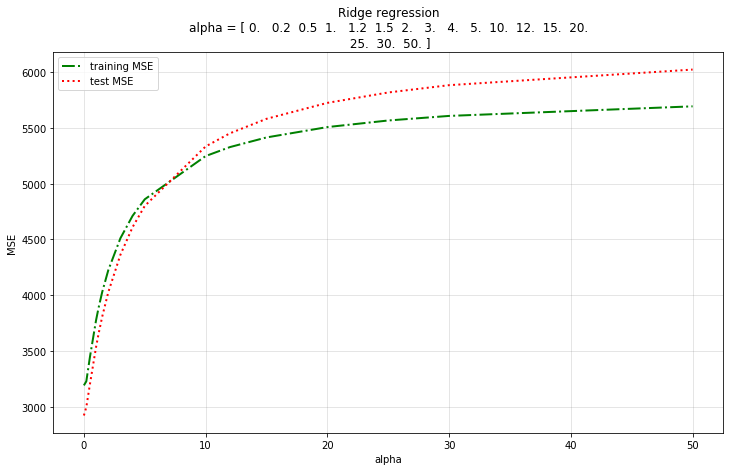

In [43]:
plot_learning_curves_increase_alpha(shrinkage='ridge')

/Users/edithzeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/Users/edithzeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/edithzeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/edithzeng/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/U

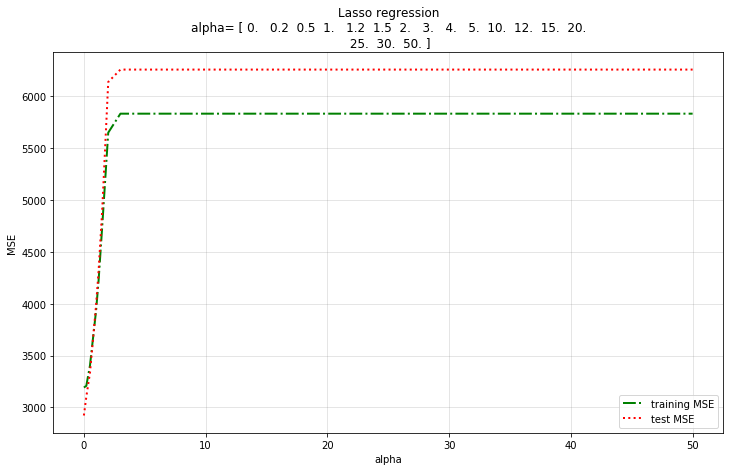

In [44]:
plot_learning_curves_increase_alpha(shrinkage='lasso')